<a href="https://colab.research.google.com/github/INCREDIBLE-AURNOB/object-detection-yolov5/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install opendatasets --quiet
!git clone https://github.com/ultralytics/yolov5 --quiet # clone repo
!pip3 install -qr yolov5/requirements.txt --quiet # install dependencies

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.3/616.3 kB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [2]:
import opendatasets as od

In [3]:
dataset=od.download("https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alrafiaurnob
Your Kaggle Key: ··········


100%|██████████| 87.6M/87.6M [00:05<00:00, 16.8MB/s]


In [4]:
dataset

In [5]:
import os
import ast
import shutil as sh
from pathlib import Path
import random

import numpy as np
import pandas as pd
import PIL

import torch
from tqdm.auto import tqdm
from IPython.display import Image,clear_output
import matplotlib.pyplot as plt
%matplotlib inline


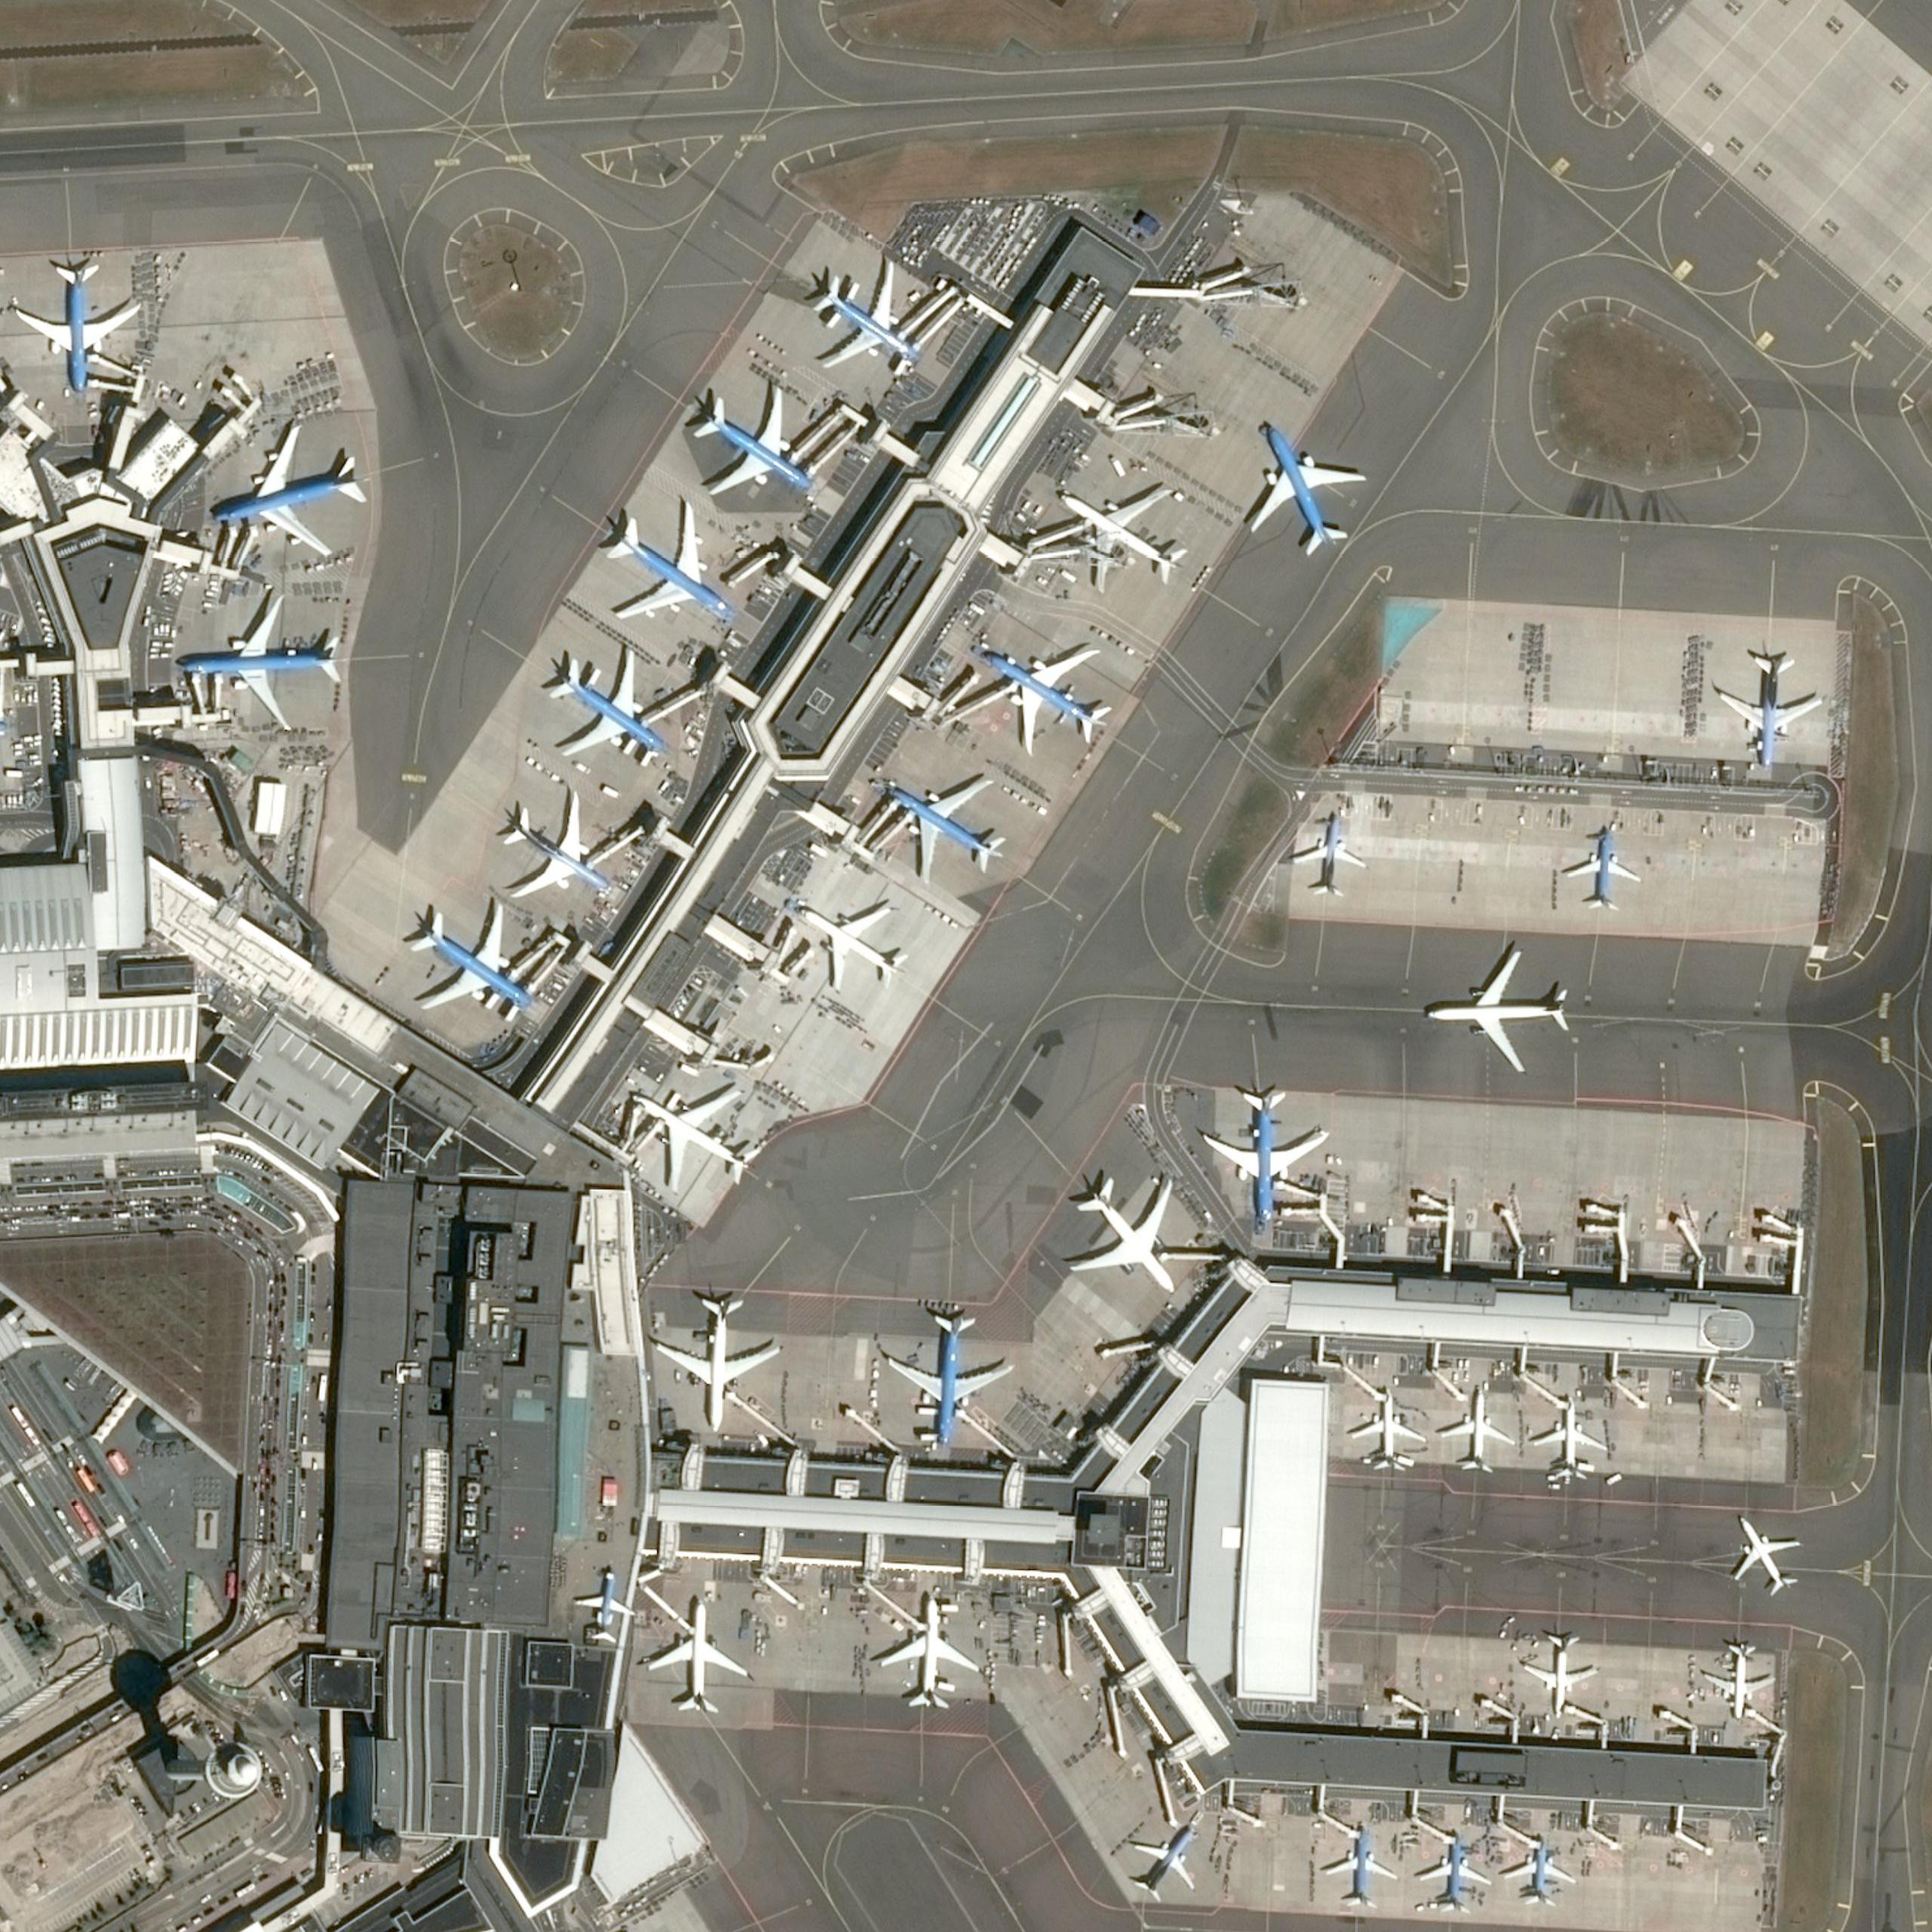

In [6]:
DATA_DIR=Path('/content/airbus-aircrafts-sample-dataset')
img_list=list(DATA_DIR.glob('images/*.jpg'))
rand=random.choice(img_list)
img=PIL.Image.open(rand)
display(img)

In [7]:
only_files = [DATA_DIR / f.name for f in img_list if os.path.isfile(f) and f.name[-4:] == ".jpg"]
print("Total image {} in ".format(len(only_files),DATA_DIR))
IMAGE_HEIGHT , IMAGE_WIDTH=img.size
num_channels=len(img.mode)
print("Image size:{}".format((IMAGE_HEIGHT,IMAGE_WIDTH)))
print("Num Channels :",num_channels)

Total image 103 in 
Image size:(2560, 2560)
Num Channels : 3


## Annotations



In [8]:
def f(x):
  return ast.literal_eval(x.strip('\r\n'))

df=pd.read_csv(DATA_DIR/"annotations.csv",
               converters={'geometry':f,'class':lambda o:'Aircraft'})

In [9]:
df.head(10)

id                                  image_id  \
0   1  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
1   2  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
2   3  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
3   4  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
4   5  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
5   6  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
6   7  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
7   8  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
8   9  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
9  10  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   

                                            geometry     class  
0  [(135, 522), (245, 522), (245, 600), (135, 600...  Aircraft  
1  [(1025, 284), (1125, 284), (1125, 384), (1025,...  Aircraft  
2  [(1058, 1503), (1130, 1503), (1130, 1568), (10...  Aircraft  
3  [(813, 1518), (885, 1518), (885, 1604), (813, ...  Aircraft  
4  [(594, 938), (657, 938), (657, 1012), (594, 10...  Aircraft  
5  [(451, 725), (524, 725), (524, 798), (451, 798...  Aircraft  
6  [(1543, 1437), (1614, 1437), (1614, 1497), (15...  Aircraft  
7  [(1485, 1370), (1561, 1370), (1561, 1437), (14...  Aircraft  
8  [(1968, 1624), (2053, 1624), (2053, 1687), (19...  Aircraft  
9  [(1659, 1674), (1733, 1674), (1733, 1746), (16...  Aircraft

In [10]:
def getBounds(geometry):
  try:
    arr=np.array(geometry).T
    xmin=np.min(arr[0])
    ymin=np.min(arr[1])
    xmax=np.max(arr[0])
    ymax=np.max(arr[1])
    return (xmin,ymin,xmax,ymax)
  except:
    return np.nan

def getWidth(bounds):
  try:
    (xmin,ymin,xmax,ymax)=bounds
    return np.abs(xmax-xmin)
  except:
    return np.nan

def getHeight(bounds):
  try:
    (xmin,ymin,xmax,ymax)=bounds
    return np.abs(ymax-ymin)
  except:
    return np.nan

#Create bounds,width,height
df.loc[:,'bounds']=df.loc[:,'geometry'].apply(getBounds)
df.loc[:,'width']=df.loc[:,'bounds'].apply(getWidth)
df.loc[:,'height']=df.loc[:,'bounds'].apply(getHeight)

In [11]:
df.head()

id                                  image_id  \
0   1  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
1   2  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
2   3  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
3   4  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
4   5  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   

                                            geometry     class  \
0  [(135, 522), (245, 522), (245, 600), (135, 600...  Aircraft   
1  [(1025, 284), (1125, 284), (1125, 384), (1025,...  Aircraft   
2  [(1058, 1503), (1130, 1503), (1130, 1568), (10...  Aircraft   
3  [(813, 1518), (885, 1518), (885, 1604), (813, ...  Aircraft   
4  [(594, 938), (657, 938), (657, 1012), (594, 10...  Aircraft   

                     bounds  width  height  
0      (135, 522, 245, 600)    110      78  
1    (1025, 284, 1125, 384)    100     100  
2  (1058, 1503, 1130, 1568)     72      65  
3    (813, 1518, 885, 1604)     72      86  
4     (594, 938, 657, 1012)     63      74

### Validation split

In [12]:
#Create a list of images used for validation
fold=1
num_fold=5
index=df['image_id'].unique()
print(len(index))
val_indexes = index[len(index)*fold//num_fold:len(index)*(fold+1)//num_fold]
print(len(val_indexes))
print(val_indexes)

103
21
['78099b50-f2b6-4319-b462-f33df2966c45.jpg'
 '22291e0b-ebe2-4f3f-b53e-4e709179300a.jpg'
 'cc4f3226-c262-409e-a4b2-a576e776f7f4.jpg'
 '34ae857d-6e71-46b9-b694-d9e40fb093bc.jpg'
 '5c9e817a-dc4b-42ab-952c-3128e2de12e8.jpg'
 'af67041b-f363-47ae-8ddd-f652db3a6bab.jpg'
 '0263270b-e3ee-41dc-aeef-43ff77e66d5b.jpg'
 'd8873734-016a-4b9d-9b9e-8bc47eb13fef.jpg'
 'd0c3d270-f23e-4792-bac0-142a9cc8ccc6.jpg'
 '78400c58-1a7c-4342-a1fb-2117cb7cbc8b.jpg'
 '77f7b57f-5cf2-424d-a952-9847b3c3f35e.jpg'
 'd9399a45-6745-4e59-8903-90640b2ddf9f.jpg'
 '014de911-7810-4f7d-8967-3e5402209f4a.jpg'
 'd3d2b706-9017-41f4-b57e-469038daa634.jpg'
 '4c9d2482-788c-4d68-a3d4-478b2367abce.jpg'
 '576827bc-a94a-4611-8820-f3d56e969151.jpg'
 '4e9164aa-532e-4b76-bce4-060b090da357.jpg'
 '14436c8c-93ec-41af-9fbf-43a5f39f2b98.jpg'
 '7635d63c-6b97-4c9c-a7dc-27773d42ed4c.jpg'
 'ecfe7982-05e5-435f-824b-e24b6846316e.jpg'
 '8df07836-4606-446e-9880-6ed9e0f74543.jpg']


## Tiling
The images are too big for YOLO to learn correctly. We need to make smaller images (or tiles). There are multiple options to do this. Here, we generate the tiles in advance with a selected size of 512 pixels by 512 pixels. In order to make sure that every aircraft can be seen by the network in full, we allow for an overlap of 64 pixels between the tiles. And we generate the tiles in the folder /kaggle/working.

In [14]:

import os
import tqdm.notebook

# Create 512x512 tiles with 64 pix overlap in /kaggle/working
TILE_WIDTH = 512
TILE_HEIGHT = 512
TILE_OVERLAP = 64
TRUNCATED_PERCENT = 0.3
_overwriteFiles = True

TILES_DIR = {'train': Path('/content/train/images'),
             'val': Path('/content/val/images')}
for _, folder in TILES_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

LABELS_DIR = {'train': Path('/content/train/labels'),
              'val': Path('/content/val/labels')}
for _, folder in LABELS_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

# Save one line in .txt file for each tag found inside the tile
def tag_is_inside_tile(bounds, x_start, y_start, width, height, truncated_percent):
    x_min, y_min, x_max, y_max = bounds
    x_min, y_min, x_max, y_max = x_min - x_start, y_min - y_start, x_max - x_start, y_max - y_start

    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None

    x_max_trunc = min(x_max, width)
    x_min_trunc = max(x_min, 0)
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < truncated_percent:
        return None

    y_max_trunc = min(y_max, width)
    y_min_trunc = max(y_min, 0)
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < truncated_percent:
        return None

    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height

    return (0, x_center, y_center, x_extend, y_extend)

for img_path in tqdm.notebook.tqdm(img_list):
    # Open image and related data
    pil_img = PIL.Image.open(img_path, mode='r')
    np_img = np.array(pil_img, dtype=np.uint8)

    # Get annotations for image
    img_labels = df[df["image_id"] == img_path.name]
    #print(img_labels)

    # Count number of sections to make
    X_TILES = (IMAGE_WIDTH + TILE_WIDTH - TILE_OVERLAP - 1) // (TILE_WIDTH - TILE_OVERLAP)
    Y_TILES = (IMAGE_HEIGHT + TILE_HEIGHT - TILE_OVERLAP - 1) // (TILE_HEIGHT - TILE_OVERLAP)

    # Cut each tile
    for x in range(X_TILES):
        for y in range(Y_TILES):

            x_end = min((x + 1) * TILE_WIDTH - TILE_OVERLAP * (x != 0), IMAGE_WIDTH)
            x_start = x_end - TILE_WIDTH
            y_end = min((y + 1) * TILE_HEIGHT - TILE_OVERLAP * (y != 0), IMAGE_HEIGHT)
            y_start = y_end - TILE_HEIGHT
            #print(x_start, y_start)

            folder = 'val' if img_path.name in val_indexes else 'train'
            save_tile_path = TILES_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".jpg")
            save_label_path = LABELS_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".txt")

            # Save if file doesn't exit
            if _overwriteFiles or not os.path.isfile(save_tile_path):
                cut_tile = np.zeros(shape=(TILE_WIDTH, TILE_HEIGHT, 3), dtype=np.uint8)
                cut_tile[0:TILE_HEIGHT, 0:TILE_WIDTH, :] = np_img[y_start:y_end, x_start:x_end, :]
                cut_tile_img = PIL.Image.fromarray(cut_tile)
                cut_tile_img.save(save_tile_path)

            found_tags = [
                tag_is_inside_tile(bounds, x_start, y_start, TILE_WIDTH, TILE_HEIGHT, TRUNCATED_PERCENT)
                for i, bounds in enumerate(img_labels['bounds'])]
            found_tags = [el for el in found_tags if el is not None]

            # save labels
            with open(save_label_path, 'w+') as f:
                for tags in found_tags:
                    f.write(' '.join(str(x) for x in tags) + '\n')

  0%|          | 0/103 [00:00<?, ?it/s]

In [15]:
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: /content/train
val: /content/val

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""
with open("dataset.yaml","w") as f:
  f.write(CONFIG)

In [16]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


## Logging

In [17]:
!pip3 uninstall -y wandb

In [18]:
!rm -rf /content/yolov5/runs

In [19]:
# !python /content/yolov5/train.py --img 512 --batch 16 --epochs 10 --data dataset.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-216-gec690e4 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.

In [61]:
!ls yolov5/runs/train/exp

ls: cannot access 'yolov5/runs/train/exp': No such file or directory


In [62]:
# predictions on batch 1
# Image(filename='/content/yolov5/runs/train/exp/opt.yaml weights', width=800)